In [115]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"parkjeongyeol","key":"c69d9ceac78f62b7c3562530bc416732"}'}

In [116]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes         64           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        148           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge        199           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       1593           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      50252            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [117]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [118]:
!unzip skin-cancer-mnist-ham10000.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_

## Data Description

각 이미지에 대한 이진 대상을 예측하고 있습니다. 모델은 이미지의 병변이 악성(표적)일 확률(부동 소수점)을 0.0과 1.0 사이에서 예측해야 합니다. 훈련 데이터 train.csv에서 값 0은 양성, 1은 악성을 나타냅니다.

- image_name - 고유 식별자, 관련 DICOM 이미지의 파일 이름을 가리킵니다.
- patient_id - 고유한 환자 식별자
- sex  - 환자의 성별(알 수 없는 경우 비어 있음)
- age_approx - 이미징 시 대략적인 환자 나이
- anatom_site_general_challenge - 이미지 사이트의 위치
- diagnosis  - 자세한 진단 정보(train only)
- benign_malignant - 영상화된 병변의 악성 지표
- target - 대상 변수의 이진화된 버전

In [119]:
import os, cv2, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# pytorch libraries
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
plt.style.use('ggplot')

In [120]:
data_dir = '/content/'

all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0] : x for x in all_image_path}

lession_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

label_mapping = {
       0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [121]:
data = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

In [122]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [123]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lession_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [124]:
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [125]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


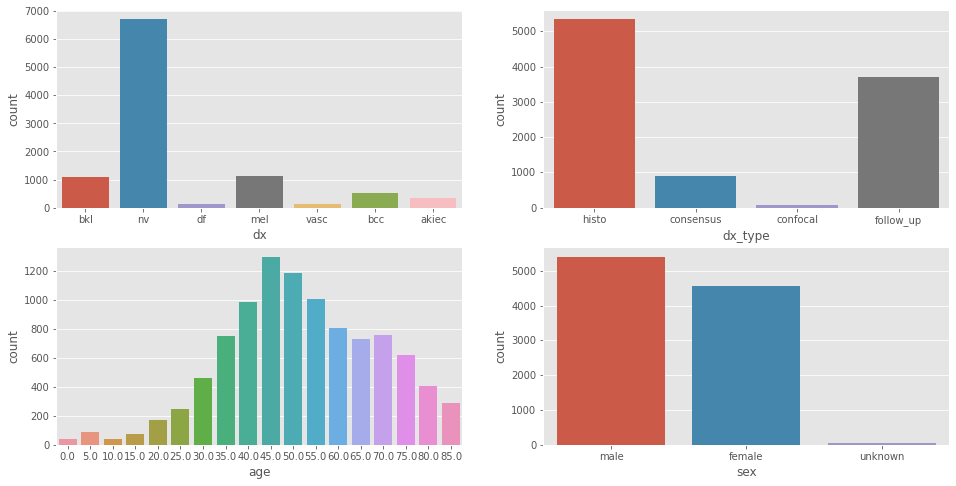

In [126]:
# 그래프를 그려서 확인해보자.
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(ncols = 2, nrows = 2, figsize = (16,8))
# target변수의 불균형이 심한 것으로 보인다.
sns.countplot(data['dx'], ax = ax1)
sns.countplot(data['dx_type'], ax = ax2)
# 나이는 5살 간격으로 끊어져 있다.
sns.countplot(data['age'], ax = ax3)

# unKnown -> 아마 데이터의 결측치가 아닐까 싶다.
sns.countplot(data['sex'],  ax = ax4)

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [128]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [129]:
# 어떤 방식으로 채워줄지 모르겠어서 dropna를 사용한다~
data = data.dropna().reset_index(drop = True)

# 나이가 5.0, 10.0 이렇게 되어 있는 부분을 정수로 바꿔준다.
data['age'] = data['age'].astype('int')

In [130]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


In [131]:
# 나이는 5를 기준으로 끊어져 있다.
data['age'].unique()

array([80, 75, 60, 70, 55, 85, 65, 40, 50, 45, 35,  0, 30,  5, 25, 20, 10,
       15])

In [132]:
for i in ['dx','dx_type','age','sex','localization','cell_type']:
  print(f'***************************** {i} ***************************')
  print(data[i].unique())
  print()

***************************** dx ***************************
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

***************************** dx_type ***************************
['histo' 'consensus' 'confocal' 'follow_up']

***************************** age ***************************
[80 75 60 70 55 85 65 40 50 45 35  0 30  5 25 20 10 15]

***************************** sex ***************************
['male' 'female' 'unknown']

***************************** localization ***************************
['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']

***************************** cell_type ***************************
['Benign keratosis-like lesions (bkl)' 'Melanocytic nevi (nv)'
 'Dermatofibroma (df)' 'Melanoma (mel)' 'Vascular lesions (vasc)'
 'Basal cell carcinoma (bcc)' 'Actinic keratoses (akiec)']



In [133]:
# 데이터의 target을 만들어 준다.
data['label'] = data['dx'].map(reverse_label_mapping.get)

In [134]:
data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'cell_type', 'path', 'image_pixel', 'label'],
      dtype='object')

In [135]:
# 데이터의 필요없는 부분들을 제외하고 분석을 진행한다.
data = data.drop(['lesion_id','image_id','dx','path'], axis = 1)

In [136]:
data.head()

,dx_type,age,sex,localization,cell_type,image_pixel,label
0,histo,80,male,scalp,Benign keratosis-like lesions (bkl),"[[[192, 153, 193], [195, 155, 192], [197, 154,...",2
1,histo,80,male,scalp,Benign keratosis-like lesions (bkl),"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ...",2
2,histo,80,male,scalp,Benign keratosis-like lesions (bkl),"[[[192, 138, 153], [200, 144, 162], [202, 142,...",2
3,histo,80,male,scalp,Benign keratosis-like lesions (bkl),"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],...",2
4,histo,75,male,ear,Benign keratosis-like lesions (bkl),"[[[159, 114, 140], [194, 144, 173], [215, 162,...",2


# ML modeling

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9958 entries, 0 to 9957
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dx_type       9958 non-null   object
 1   age           9958 non-null   int64 
 2   sex           9958 non-null   object
 3   localization  9958 non-null   object
 4   cell_type     9958 non-null   object
 5   image_pixel   9958 non-null   object
 6   label         9958 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 544.7+ KB


In [138]:
# 패키지 불러오기
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# label이 int형태로 되어있기 때문에 
data['label'] = data['label'].astype('str')

In [152]:
# dummy = pd.get_dummies(data = data, columns = ['dx_type','age','sex','localization','cell_type']).drop('image_pixel', axis = 1)
# dummy

,label,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo,age_0,age_5,age_10,age_15,age_20,age_25,age_30,age_35,age_40,age_45,age_50,age_55,age_60,age_65,age_70,age_75,age_80,age_85,sex_female,sex_male,sex_unknown,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,cell_type_Actinic keratoses (akiec),cell_type_Basal cell carcinoma (bcc),cell_type_Benign keratosis-like lesions (bkl),cell_type_Dermatofibroma (df),cell_type_Melanocytic nevi (nv),cell_type_Melanoma (mel),cell_type_Vascular lesions (vasc)
0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9954,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9955,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9956,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [164]:
# # image_pixel = (28,28,3) -> 하나의 사진에 2352개의 숫자가 들어가 있다.
# image_data = data[['image_pixel','label']]

# image_data['image_pixel'] = image_data['image_pixel'].apply(lambda x: np.array(x).reshape(1,2352))

# ML_data = pd.DataFrame([])
# for i in image_data['image_pixel']:
#   i = pd.DataFrame(i)
#   ML_data = pd.concat([ML_data, i], axis = 0)

# ML_data = ML_data.reset_index(drop = True)
# ML_data['label'] = image_data['label']

# # 머신러닝 부분에서 더미화 한 부분을 사용한다면 결과과 더 좋아질 것이라고 예상한다.

In [168]:
# 이 부분이 좀 오래 걸리는 것 같다... ㅎㅎ
# ML_data = pd.concat([ML_data, dummy], axis = 1)

In [190]:
# X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7966 entries, 2389 to 7270
Columns: 2353 entries, 0 to label
dtypes: object(1), uint8(2352)
memory usage: 18.0+ MB


In [194]:
# from sklearn.preprocessing import LabelBinarizer
# target = ML_data['label']


# target = LabelBinarizer().fit_transform(target)
# from xgboost import XGBClassifier

# # 머신러닝 수행하기
# X_train, X_test, y_train, y_test = train_test_split(ML_data.drop('label', axis = 1), ML_data['label'] ,test_size = 0.2, random_state = 42)
# y_pred = OneVsRestClassifier(XGBClassifier(random_state = 42)).fit(X_train, y_train).predict(X_test)

# # confusion matrix 활용하기
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)

array([[1272,   16,   38,    9,    1,    0,    0],
       [ 159,   34,   24,    3,    4,    0,    1],
       [ 114,    8,   80,   17,    6,    0,    0],
       [  38,    0,    9,   39,    5,    0,    0],
       [  16,    4,   14,   19,   12,    0,    0],
       [  12,    0,    0,    3,    1,    5,    0],
       [  21,    1,    3,    3,    0,    0,    1]])

In [196]:
# acc 0.72가 나오게 된다.
# np.mean(y_test == y_pred)

0.7243975903614458

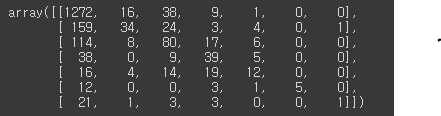

- acc -> 0.7243975903614458

# DL modeling

In [ ]:
# 후... 이제 딥러닝.. 내일 하자... ㅎㅎ 뮈뤼ㅏ눙리;무니룸니;ㅜㄹ;ㅣㅏㄴ구라ㅣ;눔이;라ㅡㄴ이;ㅏ룬이ㅏ룸니;ㅟㄼ젠아ㅜ지우마ㅣㅜ애ㅑㅏㄴㅇㄹ